# Characterizing dispersion metrics for deDANSy

Here, we show how we decided that the interquartile range can be used to robustly describe the dispersion of network separation values during pruning in the deDANSy algorithm. For this analysis, we use the HAS overexpression, SOX10-deficiency, and adipocyte culturing methods to characterize the effects of different dispersion metrics.

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from pybiomart import Dataset
import seaborn as sns
import random
from tqdm import tqdm
import scipy.stats as stats

from enrichment_helpers import *
import generateCompleteProteome
import ngramNets


In [2]:
# For reproducibility
random.seed(882)

In [3]:
# Creating some default parameters for future plots.
plt.rcParams['font.size'] = 6
plt.rcParams['axes.labelsize'] = 6
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.pad_inches'] = 0.01
plt.rcParams['legend.edgecolor'] = 'k'
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 3
plt.rcParams['scatter.edgecolors'] = 'k'
plt.rcParams['legend.fontsize'] = 'small'


In [4]:
# Importing the entire proteome that serves as a basis for all the other analyses.

complete_ref,_ = generateCompleteProteome.import_proteome_files()

# Network drawing aesthetic parameters which will be used for consistency across network graphs.
net_draw_params = {'node_size':1, 'edgecolors':'k',
        'edge_color':'#808080', 'width':0.1, 'linewidths':0.2}

In [5]:
# pybiomart database for gene name conversions
dataset = Dataset(host = 'http://useast.ensembl.org', name='hsapiens_gene_ensembl',)
gene_ID_conv = dataset.query(attributes=['ensembl_gene_id','external_gene_name','external_synonym','uniprotswissprot'])

## Generating the DANSy objects for each dataset

In [6]:
hasOE_dataset = pd.read_csv('DEG_data/MCF10_HAS_overexpression.csv')
hasOE_deg = ngramNets.DEdansy(hasOE_dataset, gene_ID_conv, data_ids=['ensembl_gene_id','external_gene_name'], uniprot_ref=complete_ref, dbl_check=True)

The following parameters were ignored:['dbl_check']
Starting to fetch n-grams.
Finished getting all n-grams
Starting to generate adjacency
Finished building adjacency.
Building the reference network information.


In [7]:
# integrating the adipocyte dataset as well to show how well that translates too
# Expanding the list of changes to include the adipocyte dataset
adipocyte_df = pd.read_csv('DEG_data/Adipocyte_Culture_Methods_DEG_Results.csv')
adipo_nets = ngramNets.DEdansy(adipocyte_df, gene_ID_conv,uniprot_ref=complete_ref, data_ids='gene_id')
adipo_conds = ['Float_v_Diff','Float_v_TW','Float_v_Explant','Float_v_Fresh','Float_v_Packed','Packed_v_Diff','Explant_v_Whole','Diff_v_Undiff']

Starting to fetch n-grams.
Finished getting all n-grams
Starting to generate adjacency
Finished building adjacency.
Building the reference network information.


In [8]:
sox10_dataset = pd.read_csv('DEG_data/SOX10_Invasion_DEG_Results.csv')
sox10_nets = ngramNets.DEdansy(sox10_dataset, gene_ID_conv,uniprot_ref=complete_ref, data_ids='ensembl_gene_id')
sox10_conds = ['4-11_v_A375','2-18_v_A375','4-11_v_2-18','CRT34_v_A375', 'CRT35_v_A375','CRT35_v_CRT34','CRT34_v_CRT34drug','CRT35_v_CRT35drug','CRT34_v_2-18', 'CRT34_v_4-11','CRT35_v_2-18', 'CRT35_v_4-11']
permissive_sox_conds = ['CRT35_v_CRT34','CRT34_v_CRT34drug','CRT35_v_CRT35drug']

Starting to fetch n-grams.
Finished getting all n-grams
Starting to generate adjacency
Finished building adjacency.
Building the reference network information.


## Exploring different dispersion metrics.

While network separation gives a whole network description of how distinct the protein functionality underlying two phenotypes, this can be influenced or skewed by n-grams associated with few proteins that make up a small fraction of all DEGs. To describe the stability of different neighborhoods, we begin pruning nodes of their DEG designation based on how over-represented contributing proteins are within the complete DEG population relative to the complete proteome. Here, we calculate the enrichment probability of each n-gram using the hypergeometric distribution and prune nodes based on different p-value threshold. At each threshold the network separation is calculated.

As n-grams are pruned, the network separation can change especially if there are distinct neighborhoods that define the two conditions, which lose connections as nodes are pruned of their DEG status. Thus, we need a metric that measures this variability, but also is robust to outliers. Here, we explore 4 different dispersion metrics to show how we determine IQR is how we describe robust yet distinct n-gram subnetworks.

In [9]:
# Here identifying and retrieving different variability measurements that can potentially highlight potential distinct neighborhood enrichment.

# Establishing sweeps and dataframes
p_vals_sweep = np.logspace(0,-10, num=21)
p_vals_sweep = np.array(sorted(np.append(p_vals_sweep, [0.5,.05]),reverse=True))
ns_dict = {} # For plotting purposes.
ns_var = pd.DataFrame(columns=['Std','CV','IQR','MAD'])

# Going through the Sox10 first (the unique conditions have been previously defined.)
for cond in tqdm(sox10_conds, desc='Sox10 dataset'):
    if cond in permissive_sox_conds:
        alpha = 0.01
        fc = 1
    else:
        alpha = 0.001
        fc = 2
    sox10_nets.calc_DEG_ngrams(data_cols=['log2FoldChange_'+cond,'padj_'+cond],contrast_name='HAS3 Overexpression', alpha = alpha, fc_thres=fc, batch_mode=True)
    
    # Now going through each of the conditions and getting the hypergeometric p-value for each n-gram node 
    ns_vals = hypergeom_prune_ns(sox10_nets, p_vals_sweep)
    ns_dict[cond] = ns_vals
    
    # Variability and dropping any influences by nans
    ns_var.loc[cond,'Std'] = np.nanstd(ns_vals)
    ns_var.loc[cond,'CV'] = np.nanstd(ns_vals)/np.nanmean(ns_vals)
    ns_var.loc[cond,'IQR'] = stats.iqr(ns_vals,nan_policy='omit')
    ns_var.loc[cond,'MAD'] = stats.median_abs_deviation(ns_vals,nan_policy='omit')


for cond in tqdm(['HAS2', 'HAS3'], desc='HASOE dataset'):
    hasOE_deg.calc_DEG_ngrams(data_cols=['log2FoldChange_'+cond,'padj_'+cond], batch_mode=True) 
    # Pruning
    ns_vals = hypergeom_prune_ns(hasOE_deg, p_vals_sweep)
    cond_name = cond + '_v_Control'
    ns_dict[cond_name] = ns_vals
    ns_var.loc[cond_name,'Std'] = np.nanstd(ns_vals)
    ns_var.loc[cond_name,'CV'] = np.nanstd(ns_vals)/np.nanmean(ns_vals)
    ns_var.loc[cond_name,'IQR'] = stats.iqr(ns_vals,nan_policy='omit')
    ns_var.loc[cond_name,'MAD'] = stats.median_abs_deviation(ns_vals,nan_policy='omit')


for cond in tqdm(adipo_conds, desc='Adipocyte dataset'):
    adipo_nets.calc_DEG_ngrams(data_cols=['log2FoldChange_'+cond,'padj_'+cond],alpha=0.0001, fc_thres=3, batch_mode=True)
    ns_vals = hypergeom_prune_ns(adipo_nets, p_vals_sweep)
    ns_dict[cond] = ns_vals

    # Here checking how variable the network separation values are to find either consistently increasing or highly variable ones
    ns_var.loc[cond,'Std'] = np.nanstd(ns_vals)
    ns_var.loc[cond,'CV'] = np.nanstd(ns_vals)/np.nanmean(ns_vals)
    ns_var.loc[cond,'IQR'] = stats.iqr(ns_vals,nan_policy='omit')
    ns_var.loc[cond,'MAD'] = stats.median_abs_deviation(ns_vals,nan_policy='omit')


Adipocyte dataset: 100%|██████████| 8/8 [00:11<00:00,  1.48s/it]


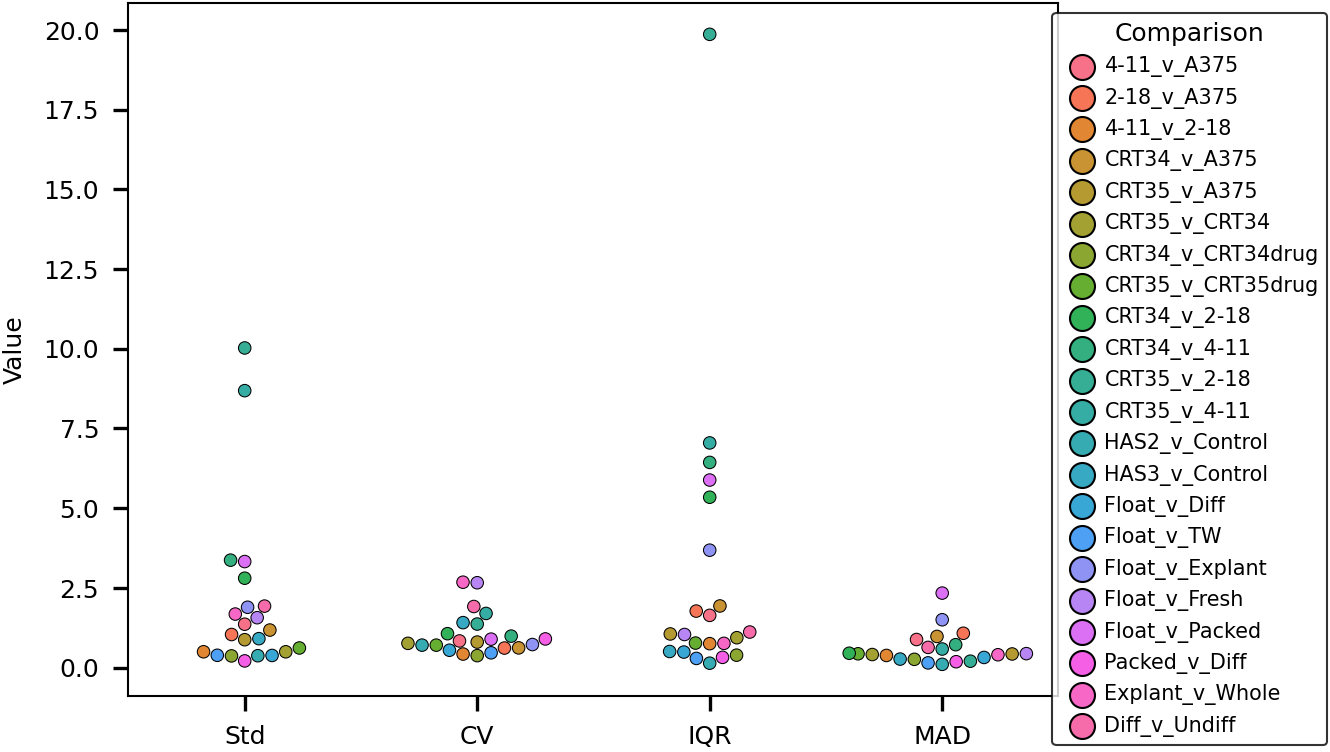

In [10]:
disp_df = ns_var.melt(ignore_index = False)
disp_df['Comparison'] = disp_df.index
plt.figure(figsize=(4,3), dpi=300)
sns.swarmplot(disp_df, x='variable', y='value', hue ='Comparison',edgecolor='k', linewidth = 0.25, size = 3)
l = plt.legend(bbox_to_anchor = (1.3,1),handletextpad=0.1, title='Comparison')

for h in l.legend_handles:
    h.set_edgecolor('k')
    h.set_linewidth(.5)
l.get_frame().set_linewidth(0.5)
plt.xlabel(None)
plt.ylabel('Value')
#plt.savefig('Figures/Manuscript Figures/Supplementary Figure deDANSy NS Variation/Dispersion_metric_comparison.svg')
plt.show()

The above plot suggests that the MAD and CV may be too robust to variability to properly identify trends. Meanwhile, the Std and IQR display a large range of values that can be used to identify different behaviors. However, the Std has an unintended property of being sensitive to outliers unlike the IQR. Thus, the IQR will be used in future analysis.

In [11]:
# Here using the IQR values to stratify the different general behaviors of network separation that are observed.
ns_chars = disp_df[disp_df['variable'] == 'IQR'].copy()

def ns_cat(x):
    if x < 1.25:
        c = 'Low'
    elif x >= 1.25 and x < 2.5:
        c = 'Med'
    else:
        c = 'High'
    return c


ns_chars['Type'] = ns_chars['value'].apply(ns_cat)
ns_cats = dict(zip(ns_chars['Comparison'],ns_chars['Type']))

/Users/yzv6ek/miniforge3/envs/ngram_dev/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


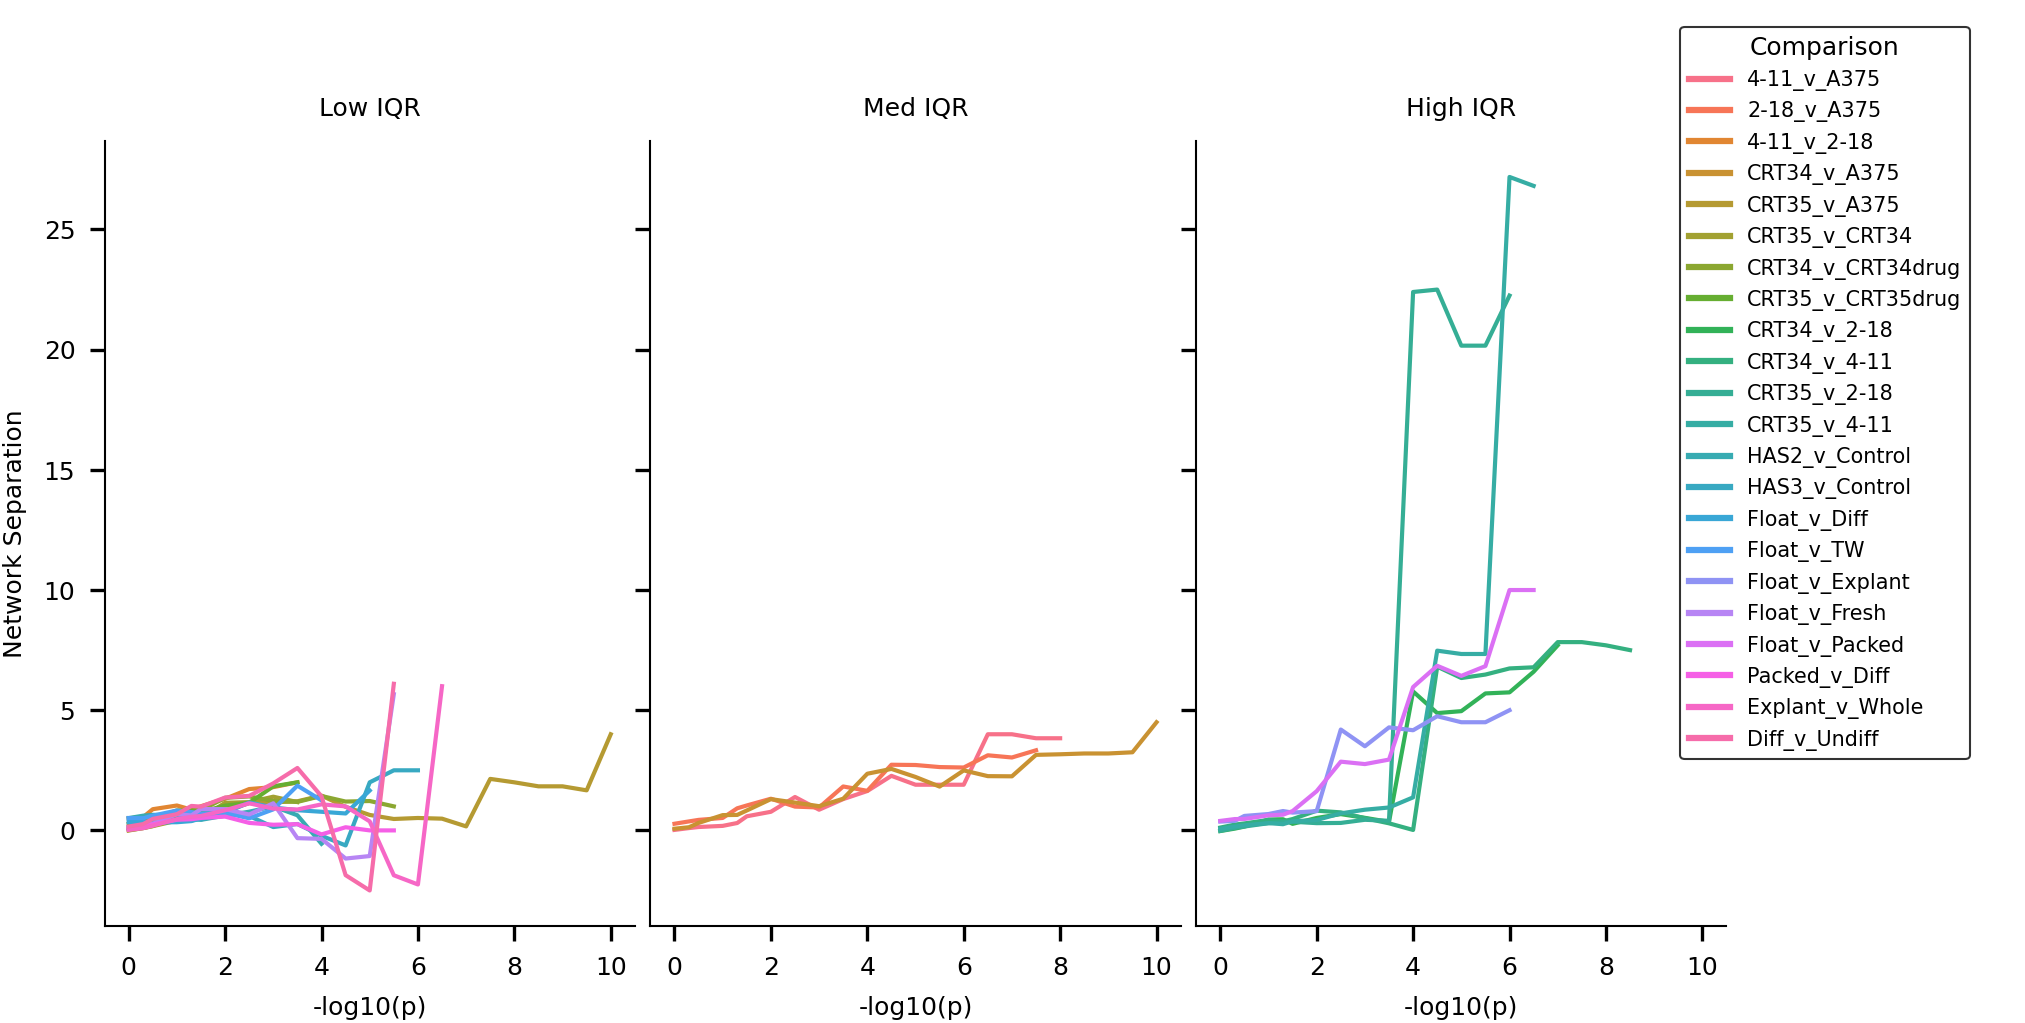

In [12]:
# Now converting to dataframe for easy plotting
ns_df = pd.DataFrame().from_dict(ns_dict, orient='index').transpose()
ns_df['p-values'] = -np.log10(p_vals_sweep)
ns_df = ns_df.melt(var_name='Condition', id_vars='p-values').dropna()
ns_df['Type'] = ns_df['Condition'].map(ns_cats)
p = sns.relplot(ns_df, x = 'p-values', y='value', hue='Condition', kind='line', col='Type', col_order=['Low','Med','High'], lw=1)

l = p.legend
l.set_frame_on(True)
l.get_frame().set_linewidth(0.5)
l.set_bbox_to_anchor((1.1,0.7))
p.figure.set_dpi(300)
p.figure.set_size_inches(6,3)
l.set_title('Comparison')
p.set_axis_labels('-log10(p)','Network Separation')
p.set_titles(col_template="{col_name} IQR")
#plt.savefig('Figures/Manuscript Figures/Supplementary Figure deDANSy NS Variation/Example_NS_Spreads.svg')
plt.show()